In [202]:
%matplotlib inline

In [203]:
import nltk 
import networkx as nx
import numpy as np
import pandas as pd
from nltk.corpus import wordnet as wn
from tqdm import tqdm
import scipy
from scipy import sparse as sp
from scipy.sparse.linalg import eigs
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans

from helpers import (
    signed_layout, draw_nodes, draw_edges, flatten, signed_laplacian, 
    normalized_laplacian, signed_normalized_laplacian, conductance_by_sweeping,
    dict2array, signed_group_conductance,
    get_borderless_fig
)

from algorithms.pagerank import pr_score
from motif_adjacency import motif_eef

In [204]:
raw_g = nx.read_gpickle('graphs/thesaurus.pkl')

In [205]:
node2word = {n: w for n, w in enumerate(raw_g.nodes())}
word2node = {w: n for n, w in enumerate(raw_g.nodes())}

In [206]:
g = nx.relabel_nodes(raw_g, mapping=word2node)

In [207]:
A = nx.adj_matrix(g, weight='sign')
W = motif_eef(A)
g_motif = nx.from_scipy_sparse_matrix(W)

In [208]:
query_word = 'angry'
query = word2node[query_word]

In [209]:
pr_scores = pr_score(g_motif, query, alpha=0.5, max_iter=5)

In [210]:
np.count_nonzero(pr_scores)

7154

In [211]:
deg = flatten(W.sum(axis=1))
node_scores = pr_scores / deg
node_scores[np.isnan(node_scores)] = 0 # nan due to singleton nodes
node_scores[node_scores <= 1e-10] = 0
print(np.count_nonzero(node_scores))

6847


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [212]:
order = np.argsort(node_scores)[::-1]
sweep_scores = conductance_by_sweeping(W, order)

# only consider non-nan scores
sweep_scores = sweep_scores[np.logical_not(np.isnan(sweep_scores))]
sweep_positions = np.arange(1, len(sweep_scores)+1)

/home/cloud-user/code/signed/helpers.py:424: RuntimeWarning: invalid value encountered in true_divide
  scores = num_cut / vols


best position 2840
community [3153 9472 3451 ... 3992 2090 1993]


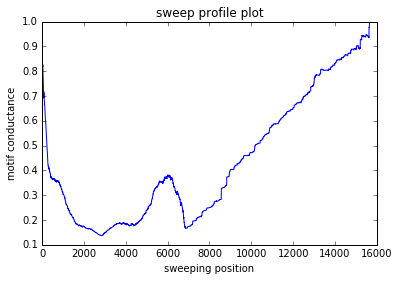

In [213]:
fig, ax = plt.subplots(1, 1)
ax.plot(sweep_positions, sweep_scores)
ax.set_title('sweep profile plot')
ax.set_xlabel('sweeping position')
ax.set_ylabel('motif conductance')

# get the best community
best_pos = np.argmin(sweep_scores)
comm = order[:best_pos+1]
print('best position', best_pos+1)
print('community', comm)

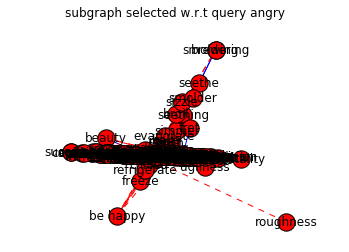

In [214]:
subg = g.subgraph(comm)
mapping = {n: i for i, n in enumerate(comm)}
subg = nx.relabel_nodes(subg, mapping=mapping)

pos = signed_layout(subg)

# subg = nx.convert_node_labels_to_integers(subg)
# subg_pos = signed_layout(subg)

# draw_nodes(subg, subg_pos)
fig, ax = get_borderless_fig()    
nx.draw_networkx_nodes(subg, pos, node_size=300)
nx.draw_networkx_labels(subg, pos, labels={mapping[n]: node2word[n] for n in comm})
draw_edges(subg, pos)
ax.set_title('subgraph selected w.r.t query {}'.format(query_word))
# fig.savefig(fig_dir + '/subgraph-selected.' + FIG_FORMAT)

In [215]:
L_subg = signed_normalized_laplacian(nx.adj_matrix(subg, weight='sign'))

0.4071180555555556
0.08402054398148148
0.09262876157407407
0.09223090277777778
0.08640769675925926
best k 3


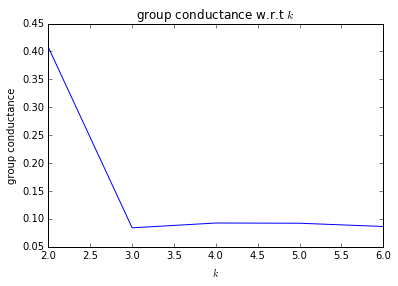

In [216]:
ks = [2, 3, 4, 5, 6]
# ks = [3]

eig_vals, eig_vects = eigs(L_subg.asfptype(), k=max(ks), which='SM')
eig_vects = eig_vects[:, np.argsort(eig_vals)]  # sort them by eigen values
eig_vects = np.real(eig_vects)

avg_phi_list = []
for k in ks:
    embedding = eig_vects[:, :k-1]  # top-k eigen vectors
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embedding)
    labels = kmeans.labels_
    groups = defaultdict(list)    
    for i, l in enumerate(labels):
        groups[l].append(i)
    avg_phi_list.append(signed_group_conductance(subg, groups.values()))
best_k = ks[np.argmin(avg_phi_list)]    
for phi in avg_phi_list:
    print(phi)
print('best k', best_k)

fig, ax = plt.subplots(1, 1)
ax.plot(ks, avg_phi_list)
ax.set_title('group conductance w.r.t $k$')
ax.set_xlabel('$k$')
ax.set_ylabel('group conductance')
# fig.savefig(fig_dir + '/group-conductance-sweep.' + FIG_FORMAT)

In [217]:
embedding = eig_vects[:, :best_k-1]  # top-(k-1) eigen vectors
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(embedding)
mapping_reverse = {v: k for k, v in mapping.items()}
groups = defaultdict(list)
for i, l in enumerate(kmeans.labels_):
    groups[l].append(node2word[mapping_reverse[i]])

In [219]:
for k, grp in groups.items():
    print('group {} ({}) {}'.format(k, len(grp), ' '.join(grp[:10])))

group 0 (427) exasperated fad storm snowstorm stir gust tempest outbreak confusion melancholy
group 1 (1229) angry enraged irate indignant irritated furious frantic resentful incensed dissatisfied
group 2 (1184) pleased peaceful vehement impassioned happy cheerful mild complacent calm untroubled
